# BO3 – Team Segmentation by Playing Style

**Business Objective:** Segment teams by playing style (aggressive, high press, defensive, clinical, set-pieces, balanced) to:
- Track tactical evolution of clubs over seasons
- Detect outliers (sudden tactical changes or atypical styles)

**Structure:** Imports → Data Loading → Feature Engineering → Scaling → Clustering (KMeans/GMM/DBSCAN) → PCA Visualization → Profiling → Style Labeling → Export

**Algorithms:** KMeans (silhouette optimization), Gaussian Mixture Models (BIC selection), DBSCAN (density-based anomalies)

**Dataset:** `team_season_aggregated.csv` - Season-level team statistics

## 1. Imports & Configuration

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('whitegrid')
sns.set_context('notebook')
plt.rcParams['figure.figsize'] = (10, 6)

RANDOM_STATE = 42
print('✅ All libraries imported successfully')

✅ All libraries imported successfully


In [20]:
# Data loading - try multiple path variations
base_path = Path('.').resolve()
team_file = base_path.parent / 'data' / 'processed' / 'team_season_aggregated.csv'

if not team_file.exists():
    # Try alternative path
    team_file = base_path / 'data' / 'processed' / 'team_season_aggregated.csv'
    
if not team_file.exists():
    raise FileNotFoundError(f'File not found at: {team_file}')

print(f'✅ Loading data from: {team_file}')
df = pd.read_csv(team_file)

print(f'\nDataset Shape: {df.shape[0]} rows × {df.shape[1]} columns')
print(f'Seasons covered: {df["Season"].min()} to {df["Season"].max()}')
print(f'Unique teams: {df["Team"].nunique()}')
print(f'\nColumns: {list(df.columns)}')

df.head()

✅ Loading data from: C:\Users\ezera\OneDrive\Desktop\4Arctic\S1\Machine Learning Appliqué\project\pl-standings-prediction-project\data\processed\team_season_aggregated.csv

Dataset Shape: 500 rows × 35 columns
Seasons covered: 2000-01 to 2024-25
Unique teams: 46

Columns: ['Season', 'Season_encoded', 'Team', 'Matches_Played', 'Home_Matches', 'Away_Matches', 'Wins', 'Draws', 'Losses', 'Home_Wins', 'Away_Wins', 'Points', 'Points_Per_Game', 'Goals_Scored', 'Goals_Conceded', 'Goal_Difference', 'Avg_Goals_Scored', 'Avg_Goals_Conceded', 'Total_Shots', 'Total_Shots_On_Target', 'Avg_Shots', 'Avg_Shots_On_Target', 'Shot_Accuracy', 'Clean_Sheets', 'Clean_Sheet_Rate', 'Yellow_Cards', 'Red_Cards', 'Fouls', 'Corners', 'Avg_Corners', 'Win_Rate', 'Home_Win_Rate', 'Away_Win_Rate', 'Final_Position', 'Team_encoded']


,Season,Season_encoded,Team,Matches_Played,Home_Matches,Away_Matches,Wins,Draws,Losses,Home_Wins,...,Yellow_Cards,Red_Cards,Fouls,Corners,Avg_Corners,Win_Rate,Home_Win_Rate,Away_Win_Rate,Final_Position,Team_encoded
0,2000-01,0,Man United,38,19,19,24,8,6,15,...,44.0,3.0,433.0,269.0,7.078947,0.631579,0.789474,0.473684,1,27
1,2000-01,0,Arsenal,38,19,19,20,10,8,15,...,48.0,3.0,495.0,295.0,7.763158,0.526316,0.789474,0.263158,2,0
2,2000-01,0,Liverpool,38,19,19,20,9,9,13,...,50.0,4.0,473.0,243.0,6.394737,0.526316,0.684211,0.368421,3,24
3,2000-01,0,Leeds,38,19,19,20,8,10,11,...,72.0,3.0,589.0,270.0,7.105263,0.526316,0.578947,0.473684,4,22
4,2000-01,0,Ipswich,38,19,19,20,6,12,11,...,31.0,2.0,414.0,206.0,5.421053,0.526316,0.578947,0.473684,5,21


## 2. Feature Selection & Preprocessing
We select a concise set of season-level indicators capturing offensive volume & efficiency, defensive solidity, set-piece activity, discipline, and overall performance.

Chosen features:
- Offensive: `Avg_Shots`, `Avg_Shots_On_Target`, `Shot_Accuracy`, `Avg_Goals_Scored`
- Defensive: `Avg_Goals_Conceded`, `Clean_Sheet_Rate`
- Set-Pieces: `Avg_Corners`
- Discipline / Intensity: `Fouls`, `Yellow_Cards`, `Red_Cards`
- Performance: `Win_Rate`

Missing values are median-imputed then standardized. PCA (2 components) is used only for visualization; clustering uses the full standardized feature set.

In [21]:
# Select features for clustering
feature_cols = [
    'Avg_Shots', 'Avg_Shots_On_Target', 'Shot_Accuracy', 'Avg_Goals_Scored',
    'Avg_Goals_Conceded', 'Clean_Sheet_Rate',
    'Avg_Corners', 'Fouls', 'Yellow_Cards', 'Red_Cards', 'Win_Rate'
]

# Validate features exist
missing = [c for c in feature_cols if c not in df.columns]
if missing:
    raise ValueError(f'Missing expected columns: {missing}')

print(f'✅ Selected {len(feature_cols)} features for clustering:')
print(f'   Offensive: Avg_Shots, Avg_Shots_On_Target, Shot_Accuracy, Avg_Goals_Scored')
print(f'   Defensive: Avg_Goals_Conceded, Clean_Sheet_Rate')
print(f'   Set-Pieces: Avg_Corners')
print(f'   Discipline: Fouls, Yellow_Cards, Red_Cards')
print(f'   Performance: Win_Rate')

# Prepare feature matrix
X = df[feature_cols].copy()
print(f'\nOriginal data shape: {X.shape}')
print(f'Missing values: {X.isnull().sum().sum()}')

# Impute missing values with median
X = X.fillna(X.median())
print(f'✅ Missing values imputed')

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(f'✅ Features standardized (mean=0, std=1)')

# PCA for visualization only (not used for clustering)
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)
print(f'\n✅ PCA computed for visualization:')
print(f'   PC1 explains {pca.explained_variance_ratio_[0]*100:.1f}% of variance')
print(f'   PC2 explains {pca.explained_variance_ratio_[1]*100:.1f}% of variance')
print(f'   Total: {pca.explained_variance_ratio_.sum()*100:.1f}%')

✅ Selected 11 features for clustering:
   Offensive: Avg_Shots, Avg_Shots_On_Target, Shot_Accuracy, Avg_Goals_Scored
   Defensive: Avg_Goals_Conceded, Clean_Sheet_Rate
   Set-Pieces: Avg_Corners
   Discipline: Fouls, Yellow_Cards, Red_Cards
   Performance: Win_Rate

Original data shape: (500, 11)
Missing values: 0
✅ Missing values imputed
✅ Features standardized (mean=0, std=1)

✅ PCA computed for visualization:
   PC1 explains 46.7% of variance
   PC2 explains 16.8% of variance
   Total: 63.5%


## 3. Clustering (KMeans & GMM)
We evaluate KMeans (k=2..8) using silhouette score and Gaussian Mixture Models (components=2..8) using BIC and silhouette to select balanced solutions.

In [22]:
# KMeans clustering with silhouette optimization
print('='*80)
print('KMEANS CLUSTERING')
print('='*80)

sil_kmeans = {}
for k in range(2, 9):
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels = km.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    sil_kmeans[k] = sil
    print(f'k={k}: silhouette = {sil:.4f}')

best_k = max(sil_kmeans, key=sil_kmeans.get)
print(f'\n✅ Best k: {best_k} (silhouette = {sil_kmeans[best_k]:.4f})')

# Fit final KMeans with best k
kmeans_final = KMeans(n_clusters=best_k, random_state=RANDOM_STATE, n_init=10)
kmeans_labels = kmeans_final.fit_predict(X_scaled)
print(f'✅ KMeans fitted with {best_k} clusters')

# GMM clustering with BIC optimization
print('\n' + '='*80)
print('GAUSSIAN MIXTURE MODEL (GMM)')
print('='*80)

results_gmm = []
for c in range(2, 9):
    gmm = GaussianMixture(n_components=c, random_state=RANDOM_STATE, covariance_type='full')
    gmm_labels = gmm.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, gmm_labels)
    bic = gmm.bic(X_scaled)
    results_gmm.append({'components': c, 'silhouette': sil, 'bic': bic})
    print(f'components={c}: BIC={bic:.2f}, silhouette={sil:.4f}')

gmm_df = pd.DataFrame(results_gmm)

# Select model: lowest BIC among models with silhouette within 90% of max
max_sil = gmm_df['silhouette'].max()
threshold = 0.9 * max_sil
candidate = gmm_df[gmm_df['silhouette'] >= threshold].sort_values('bic').iloc[0]
best_components = int(candidate['components'])

print(f'\n✅ Best GMM: {best_components} components (BIC={candidate["bic"]:.2f}, silhouette={candidate["silhouette"]:.4f})')

# Fit final GMM
gmm_final = GaussianMixture(n_components=best_components, random_state=RANDOM_STATE, covariance_type='full')
gmm_labels = gmm_final.fit_predict(X_scaled)
print(f'✅ GMM fitted with {best_components} components')

KMEANS CLUSTERING
k=2: silhouette = 0.2991
k=3: silhouette = 0.2287
k=4: silhouette = 0.1919
k=5: silhouette = 0.1816
k=6: silhouette = 0.1711
k=7: silhouette = 0.1601
k=8: silhouette = 0.1577

✅ Best k: 2 (silhouette = 0.2991)
✅ KMeans fitted with 2 clusters

GAUSSIAN MIXTURE MODEL (GMM)
k=5: silhouette = 0.1816
k=6: silhouette = 0.1711
k=7: silhouette = 0.1601
k=8: silhouette = 0.1577

✅ Best k: 2 (silhouette = 0.2991)
✅ KMeans fitted with 2 clusters

GAUSSIAN MIXTURE MODEL (GMM)
components=2: BIC=10233.97, silhouette=0.2853
components=3: BIC=9090.55, silhouette=0.1753
components=4: BIC=8968.90, silhouette=0.1877
components=5: BIC=9231.17, silhouette=0.1751
components=6: BIC=9287.66, silhouette=0.1306
components=7: BIC=9576.97, silhouette=0.0861
components=2: BIC=10233.97, silhouette=0.2853
components=3: BIC=9090.55, silhouette=0.1753
components=4: BIC=8968.90, silhouette=0.1877
components=5: BIC=9231.17, silhouette=0.1751
components=6: BIC=9287.66, silhouette=0.1306
components=7: BI

## 4. DBSCAN (Density-Based)
Coarse search over eps values; min_samples kept small to allow discovery of dense style niches. We retain the model with highest silhouette (ignoring label -1).

In [23]:
# DBSCAN clustering (density-based)
print('\n' + '='*80)
print('DBSCAN (DENSITY-BASED CLUSTERING)')
print('='*80)

best_dbscan = None
best_sil = -1
best_params = None
best_labels = None

for eps in np.linspace(0.5, 3.0, 11):
    db = DBSCAN(eps=eps, min_samples=4)
    labels = db.fit_predict(X_scaled)
    unique = set(labels)
    n_clusters = len(unique) - (1 if -1 in unique else 0)
    n_noise = list(labels).count(-1)
    
    if len(unique) <= 1 or n_clusters == 0:
        continue  # All noise or single cluster
    
    # Calculate silhouette (excluding noise points)
    mask = labels != -1
    if mask.sum() < 2:
        continue
    
    try:
        sil = silhouette_score(X_scaled[mask], labels[mask])
        print(f'eps={eps:.2f}: {n_clusters} clusters, {n_noise} noise points, silhouette={sil:.4f}')
        
        if sil > best_sil:
            best_sil = sil
            best_dbscan = db
            best_params = {'eps': eps, 'min_samples': 4}
            best_labels = labels
    except:
        continue

if best_dbscan is not None:
    dbscan_labels = best_labels
    n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    n_noise = list(dbscan_labels).count(-1)
    print(f'\n✅ Best DBSCAN: eps={best_params["eps"]:.2f}, {n_clusters} clusters, {n_noise} noise points')
    print(f'   Silhouette: {best_sil:.4f}')
else:
    dbscan_labels = np.array([-1] * len(X_scaled))
    print('\n⚠️  DBSCAN found no meaningful clustering (all points classified as noise)')


DBSCAN (DENSITY-BASED CLUSTERING)
eps=1.25: 12 clusters, 409 noise points, silhouette=0.2278
eps=1.50: 7 clusters, 216 noise points, silhouette=0.1669
eps=1.75: 3 clusters, 81 noise points, silhouette=0.2390

✅ Best DBSCAN: eps=1.75, 3 clusters, 81 noise points
   Silhouette: 0.2390


## 5. Visualization (PCA 2D)
Helper plot function to visualize clusters on the 2-component PCA projection.


CLUSTER VISUALIZATIONS (PCA 2D PROJECTION)


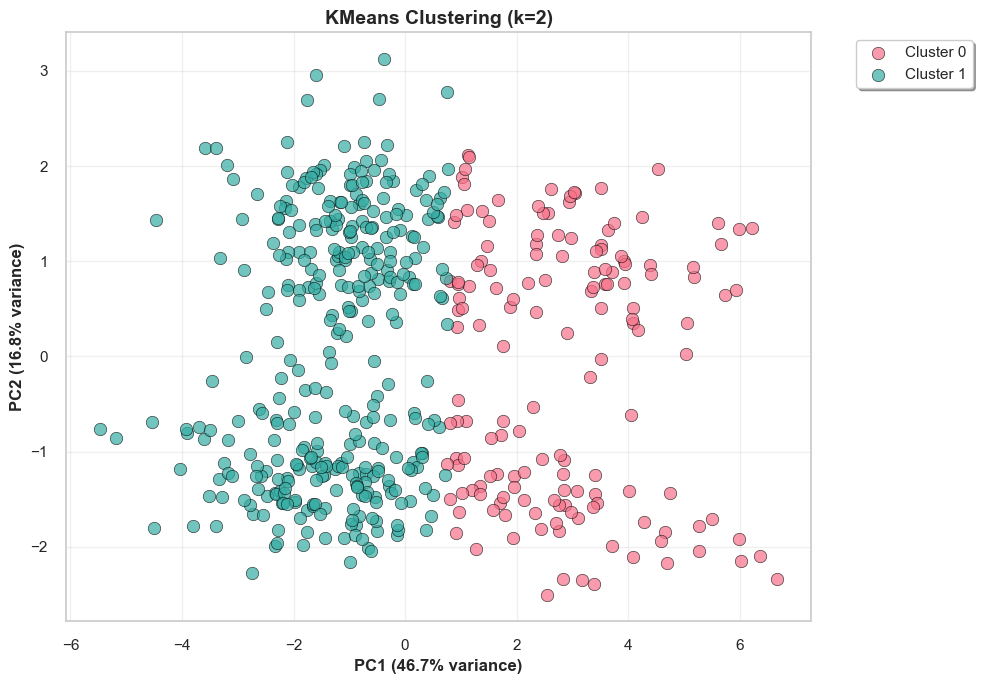

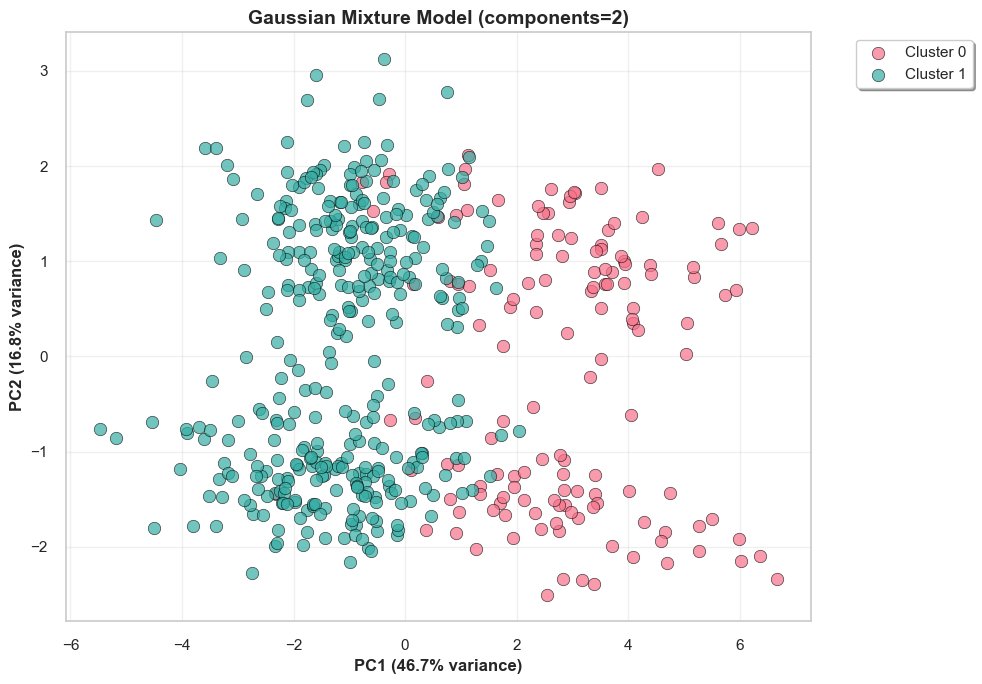

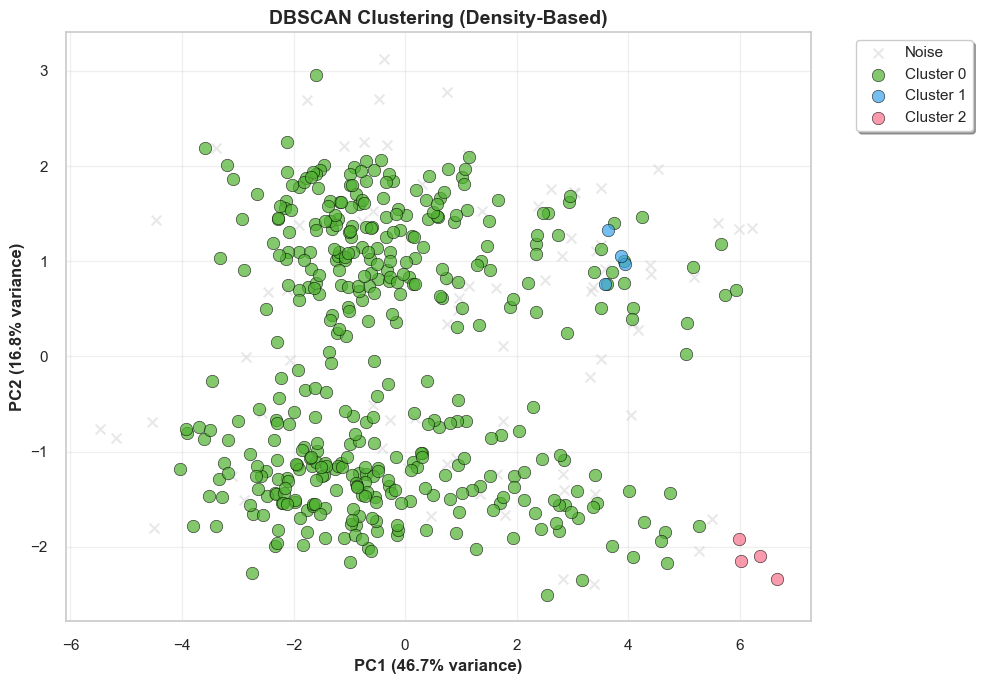

In [24]:
def plot_clusters(pca_data, labels, title):
    """Plot clusters in PCA 2D space"""
    plt.figure(figsize=(10, 7))
    unique_labels = sorted(set(labels))
    n_colors = len(unique_labels) if -1 not in unique_labels else len(unique_labels) - 1
    palette = sns.color_palette('husl', n_colors=max(n_colors, 1))
    
    for idx, lab in enumerate(unique_labels):
        mask = labels == lab
        if lab == -1:
            plt.scatter(pca_data[mask, 0], pca_data[mask, 1], 
                       c='lightgray', label='Noise', alpha=0.5, marker='x', s=50)
        else:
            color_idx = lab if -1 not in unique_labels else (lab if lab < 0 else idx)
            plt.scatter(pca_data[mask, 0], pca_data[mask, 1], 
                       color=palette[color_idx % len(palette)], 
                       label=f'Cluster {lab}', alpha=0.7, s=80, edgecolors='black', linewidth=0.5)
    
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', fontweight='bold')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', fontweight='bold')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True, shadow=True)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

print('\n' + '='*80)
print('CLUSTER VISUALIZATIONS (PCA 2D PROJECTION)')
print('='*80)

plot_clusters(X_pca, kmeans_labels, f'KMeans Clustering (k={best_k})')
plot_clusters(X_pca, gmm_labels, f'Gaussian Mixture Model (components={best_components})')
plot_clusters(X_pca, dbscan_labels, 'DBSCAN Clustering (Density-Based)')

## 6. Cluster Profiling & Style Labels
Compute feature means per cluster (KMeans chosen as baseline). Map profiles to human-readable style descriptors using threshold rules on standardized feature values.

In [25]:
# Profile KMeans clusters (chosen as primary method)
print('\n' + '='*80)
print('CLUSTER PROFILING & STYLE LABELING')
print('='*80)

profile_df = pd.DataFrame(X_scaled, columns=feature_cols)
profile_df['Cluster'] = kmeans_labels
centroids = profile_df.groupby('Cluster')[feature_cols].mean()

print(f'\nCluster Centroids (standardized feature means):')
print(centroids.round(3))

# Style labeling logic (thresholds on standardized features)
style_labels = {}
for cluster, row in centroids.iterrows():
    tags = []
    
    # High offensive volume and pressure
    if row['Avg_Shots'] > 0.5 and row['Avg_Shots_On_Target'] > 0.4:
        tags.append('High_Press')
    
    # High shot accuracy and goal efficiency
    if row['Shot_Accuracy'] > 0.6 and row['Avg_Goals_Scored'] > 0.5:
        tags.append('Clinical')
    
    # Strong defensive metrics
    if row['Avg_Goals_Conceded'] < -0.4 and row['Clean_Sheet_Rate'] > 0.4:
        tags.append('Defensive')
    
    # High corner frequency (set-piece focus)
    if row['Avg_Corners'] > 0.5:
        tags.append('SetPiece')
    
    # High fouls and cards (aggressive/physical)
    if row['Fouls'] > 0.5 or row['Yellow_Cards'] > 0.5:
        tags.append('Aggressive')
    
    # Default if no strong characteristics
    if not tags:
        tags.append('Balanced')
    
    style_labels[cluster] = '+'.join(tags)

print(f'\nStyle Labels by Cluster:')
for cluster, style in style_labels.items():
    n_teams = (kmeans_labels == cluster).sum()
    print(f'  Cluster {cluster}: {style} ({n_teams} team-seasons)')

# Create output dataframe with cluster assignments
if 'Team' in df.columns:
    output_df = df[['Season', 'Team']].copy()
else:
    output_df = df[['Season']].copy()

output_df['Cluster_KMeans'] = kmeans_labels
output_df['Style_Label'] = [style_labels[c] for c in kmeans_labels]

print(f'\n✅ Style labels assigned to {len(output_df)} team-seasons')
print(f'\nSample assignments:')
output_df.head(10)


CLUSTER PROFILING & STYLE LABELING

Cluster Centroids (standardized feature means):
         Avg_Shots  Avg_Shots_On_Target  Shot_Accuracy  Avg_Goals_Scored  \
Cluster                                                                    
0            1.074                0.902          0.240             1.107   
1           -0.482               -0.405         -0.108            -0.498   

         Avg_Goals_Conceded  Clean_Sheet_Rate  Avg_Corners  Fouls  \
Cluster                                                             
0                    -0.996             0.988        1.006 -0.373   
1                     0.448            -0.444       -0.452  0.168   

         Yellow_Cards  Red_Cards  Win_Rate  
Cluster                                     
0              -0.410     -0.226     1.168  
1               0.184      0.102    -0.525  

Style Labels by Cluster:
  Cluster 0: High_Press+Defensive+SetPiece (155 team-seasons)
  Cluster 1: Balanced (345 team-seasons)

✅ Style labels assigned

,Season,Team,Cluster_KMeans,Style_Label
0,2000-01,Man United,0,High_Press+Defensive+SetPiece
1,2000-01,Arsenal,0,High_Press+Defensive+SetPiece
2,2000-01,Liverpool,0,High_Press+Defensive+SetPiece
3,2000-01,Leeds,0,High_Press+Defensive+SetPiece
4,2000-01,Ipswich,0,High_Press+Defensive+SetPiece
5,2000-01,Chelsea,0,High_Press+Defensive+SetPiece
6,2000-01,Sunderland,1,Balanced
7,2000-01,Aston Villa,1,Balanced
8,2000-01,Charlton,1,Balanced
9,2000-01,Southampton,1,Balanced


## 7. Export & Comparison Summary
Export style assignments and provide a concise comparison of method silhouettes.

In [ ]:
# Calculate silhouette scores for all methods
print('\n' + '='*80)
print('METHOD COMPARISON & EXPORT')
print('='*80)

km_sil = silhouette_score(X_scaled, kmeans_labels)
gmm_sil = silhouette_score(X_scaled, gmm_labels)

# DBSCAN silhouette (exclude noise points if present)
if len(set(dbscan_labels)) > 1:
    if -1 in dbscan_labels:
        mask = dbscan_labels != -1
        if mask.sum() > 1:
            db_sil = silhouette_score(X_scaled[mask], dbscan_labels[mask])
        else:
            db_sil = np.nan
    else:
        db_sil = silhouette_score(X_scaled, dbscan_labels)
else:
    db_sil = np.nan

summary = pd.DataFrame({
    'Method': ['KMeans', 'GMM', 'DBSCAN'],
    'Clusters': [best_k, best_components, len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)],
    'Silhouette': [km_sil, gmm_sil, db_sil]
})
summary = summary.sort_values('Silhouette', ascending=False)

print('\nSilhouette Score Comparison:')
print(summary.to_string(index=False))

# Add GMM and DBSCAN labels to output
output_df['Cluster_GMM'] = gmm_labels
output_df['Cluster_DBSCAN'] = dbscan_labels

# Export results
export_path = team_file.parent / 'team_style_clusters.csv'
output_df.to_csv(export_path, index=False)

print(f'\n✅ Cluster assignments exported to:')
print(f'   {export_path}')
print(f'\nExported columns: {list(output_df.columns)}')
print(f'Total rows: {len(output_df)}')

print(f'\n🏆 Best Method: {summary.iloc[0]["Method"]} (Silhouette = {summary.iloc[0]["Silhouette"]:.4f})')

output_df.head(10)


METHOD COMPARISON & EXPORT

Silhouette Score Comparison:
Method  Clusters  Silhouette
KMeans         2    0.299115
   GMM         2    0.285318
DBSCAN         3    0.238979

✅ Cluster assignments exported to:
   C:\Users\ezera\OneDrive\Desktop\4Arctic\S1\Machine Learning Appliqué\project\pl-standings-prediction-project\data\processed\team_style_clusters.csv

Exported columns: ['Season', 'Team', 'Cluster_KMeans', 'Style_Label', 'Cluster_GMM', 'Cluster_DBSCAN']
Total rows: 500

🏆 Best Method: KMeans (Silhouette = 0.2991)


,Season,Team,Cluster_KMeans,Style_Label,Cluster_GMM,Cluster_DBSCAN
0,2000-01,Man United,0,High_Press+Defensive+SetPiece,0,-1
1,2000-01,Arsenal,0,High_Press+Defensive+SetPiece,0,-1
2,2000-01,Liverpool,0,High_Press+Defensive+SetPiece,0,0
3,2000-01,Leeds,0,High_Press+Defensive+SetPiece,1,-1
4,2000-01,Ipswich,0,High_Press+Defensive+SetPiece,0,-1
5,2000-01,Chelsea,0,High_Press+Defensive+SetPiece,0,-1
6,2000-01,Sunderland,1,Balanced,1,-1
7,2000-01,Aston Villa,1,Balanced,1,0
8,2000-01,Charlton,1,Balanced,1,0
9,2000-01,Southampton,1,Balanced,1,0
